# Monthly Cross-Section: Estimation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data

In [6]:
industries_monthly = pd.read_pickle('df_industries_monthly.pkl')
#industries_daily = pd.read_pickle('df_industries_daily.pkl')

## Estimation
### Setup

In [7]:
df_xs_estimates = pd.DataFrame(industries_monthly.stack().rename(('data','return')))

In [8]:
#df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

### Define outputs

In [9]:
def get_moment_vector(y):
    '''
    This function defines a vector that contains the first four moments of y
    '''
    moment_vector = \
        pd.Series([y.mean(), y.std(), y.var(), y.skew(),y.kurtosis()], index=['mean','std','var','skew','exkurt'])
    return moment_vector

In [11]:
def get_hmm_model_output(hmm_model): # TO DO: function is broken for k>2, transition probabilities wrong
    '''
    This function defines a vector with estimates from a hidden markov model object
    '''
    #sort by volatility
    sorted_indices = hmm_model.params.loc[[i[0:6]=='sigma2' for i in hmm_model.params.index]].sort_values().index
    sort_k = [int(i[7]) for i in sorted_indices]
    k = len(sort_k)
    n = int(len(hmm_model.params)/k)
    list_1 = [i*n for i in range(n) for j in range(n)]
    list_2 = sort_k*n
    sort_params = [i+j for i,j in zip(list_1,list_2)]
    
    model_output = \
        pd.Series([hmm_model.mle_retvals['converged'],algo,hmm_model.nobs,hmm_model.aic,hmm_model.bic,hmm_model.llf],index=['convergence','algorithm','T','aic','bic','likelihood'])\
            .append(pd.Series(hmm_model.params.values[sort_params],index=['p00','p10','sigma2_0','sigma2_1']))\
            .append(pd.Series(hmm_model.bse.values[sort_params],index=['p00_se','p10_se','sigma2_0_se','sigma2_1_se']))\
            .append(pd.Series(hmm_model.cov_params().loc['sigma2[0]','sigma2[1]'],index=['sigma_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['p[0->0]','p[1->0]'],index=['prob_cov']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.iloc[-1,:].values[sort_k],index=['smooth_prob_0','smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.iloc[-1,:].values[sort_k],index=['filt_prob_0','filt_prob_1']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.mean().values[sort_k],index=['mean_smooth_prob_0','mean_smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.mean().values[sort_k],index=['mean_filt_prob_0','mean_filt_prob_1']))\
            .append(pd.Series(abs(hmm_model.smoothed_marginal_probabilities.iloc[-1,:]-hmm_model.smoothed_marginal_probabilities.iloc[-2,:]).mean(),index=['smooth_prob_innov']))\
            .append(pd.Series(abs(hmm_model.filtered_marginal_probabilities.iloc[-1,:]-hmm_model.filtered_marginal_probabilities.iloc[-2,:]).mean(),index=['filt_prob_innov']))
    return model_output

In [12]:
def get_state_probabilities(hmm_model):
    '''
    This is to extract the in-sample state probabilities
    '''
    #sort by volatility
    sorted_indices = hmm_model.params.loc[[i[0:6]=='sigma2' for i in hmm_model.params.index]].sort_values().index
    sort_k = [int(i[7]) for i in sorted_indices]
    
    state_probs = \
        pd.DataFrame(hmm_model.smoothed_marginal_probabilities.values[:,sort_k], index=hmm_model.smoothed_marginal_probabilities.index, columns=['smooth_is_0','smooth_is_1'])\
            .join(pd.DataFrame(hmm_model.filtered_marginal_probabilities.values[:,sort_k], index=hmm_model.smoothed_marginal_probabilities.index, columns=['filt_is_0','filt_is_1']))
    return state_probs

### Full Sample
#### Names

In [13]:
hmm_name = 'HMM_full'
moment_name = 'moment_full'

In [14]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [15]:
%%time
count = 0
full_sample_estimates = pd.DataFrame([])

for name,data in tqdm.tqdm(industries_monthly.items()):
    
    # calculate sample moments
    moment_vector = get_moment_vector(data)
    
    # treat outliers
    y = pd.Series(data.values,index=data.index).copy()
    y = y - y.mean()
    s = y.std()
    m,s = moment_vector[['mean','std']]
    #y[y<m-2.325*s] = m-2.325*s + 0.1*(y[y<m-2.325*s]-(m-2.325*s))
    #y[y>m+2.325*s] = m+2.325*s + 0.1*(y[y>m-2.325*s]-(m+2.325*s))
    #y = calc.shrink_outliers(y,alpha=1.96,lamb=1)
    
    # set initial guesses for parameters
    init = [0.9,0.1] + [(2*s)**2] + [(0.5*s)**2]
    
    # estimate model
    for algo in algos:
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore")
            hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, trend='nc', exog=None, switching_trend=False, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False, search_reps=20)
        if (not any(hmm_model.params.isna())):
            break
            
    # outputs
    model_output = get_hmm_model_output(hmm_model)
    state_probs = get_state_probabilities(hmm_model)
    
    # safe estimates
    if count == 0 & False:
        df_xs_estimates = df_xs_estimates\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], state_probs.columns]), index=df_xs_estimates.index))
        
    full_sample_estimates = full_sample_estimates.join(model_output.rename(name),how='outer')
    
    selected_rows = \
        (df_xs_estimates.index.get_level_values('Industry')==name)\
        &np.array([x in state_probs.index for x in df_xs_estimates.index.get_level_values('Date')])
    df_xs_estimates.loc[selected_rows,(moment_name,moment_vector.index)] = moment_vector.values
    df_xs_estimates.loc[selected_rows,(hmm_name,model_output.index)] = model_output.values
    df_xs_estimates.loc[selected_rows,(hmm_name,state_probs.columns)] = state_probs.values
    
    count += 1
    
df_xs_estimates.to_pickle('df_xs_estimates_monthly_VOLA.pkl')

49it [00:55,  1.05s/it]


Wall time: 55.3 s


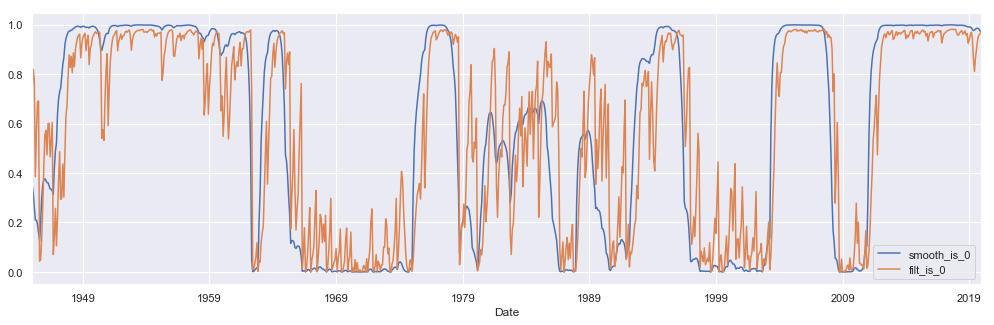

In [16]:
get_state_probabilities(hmm_model).iloc[:,[0,2]].plot(figsize=[17,5])

### Expanding Window
#### Names

In [17]:
win_yrs = 30 #length of first window

In [18]:
hmm_name = 'HMM_expand'
moment_name = 'moment_expand'

In [19]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [20]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly_VOLA.pkl')

In [21]:
%%time
start = 0
count = start

#for name,data in industries_monthly.iloc[:,start:].items():
for name,data in industries_monthly.iloc[:,:].items():
    
    # find dates to optimise
    data = data[data.notna()]
    opt_dates = data.index[data.index>data.index[0].replace(year=data.index[0].year+win_yrs)]
    
    correction_count = 0
    switch_count = 0
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        select_window = data.index[data.index<=iDate]
        y = data.loc[select_window].copy()
        y = y - y.mean()
        
        # calculate sample moments
        moment_vector = get_moment_vector(y)
        
        # treat outliers
        #y = calc.shrink_outliers(y, alpha=1.96, lamb=1) #1.645
        
        # set initial guesses for parameters
        s = y.std()
        win_init = [0.9,0.1] + [(2*s)**2] + [(0.5*s)**2]
        
        if iDate == opt_dates[0]:
            init = win_init
        else:
            if  all(hmm_model.params.notna()):
                init = hmm_model.params.values
            else:
                init = win_init
            
            # move initial transition probabilities to reasonable levels
            if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
                init = 0.9*init + 0.1*np.asarray(win_init)
                correction_count += 1
        
        # estimate model
        for algo in algos:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, trend='nc', switching_trend=False, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False, search_reps=0)
            if (not any(hmm_model.params.isna())):
                break
                
        if hmm_model.params[2] < hmm_model.params[3]:
            switch_count += 1
        
        # outputs
        model_output = get_hmm_model_output(hmm_model)
        
        # safe estimates
        if (count == 0) & (iDate == opt_dates[0]) & True:
            df_xs_estimates = df_xs_estimates\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))

        df_xs_estimates.loc[(iDate,name),(moment_name,moment_vector.index)] = moment_vector.values
        df_xs_estimates.loc[(iDate,name),(hmm_name,model_output.index)] = model_output.values
        
    count += 1
    print(name, ':', list(industries_monthly.columns).index(name)+1, '/', len(industries_monthly.columns), ',', correction_count, 'corrections, ', switch_count,'switches')
    
    df_xs_estimates.to_pickle('df_xs_estimates_monthly_VOLA.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:58<00:00,  3.50it/s]


Agric : 1 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:01<00:00,  4.21it/s]


Food  : 2 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [01:12<00:00,  3.61it/s]


Soda  : 3 / 49 , 30 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:06<00:00,  4.44it/s]


Beer  : 4 / 49 , 100 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:02<00:00,  4.46it/s]


Smoke : 5 / 49 , 19 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:16<00:00,  3.32it/s]


Toys  : 6 / 49 , 172 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:11<00:00,  4.08it/s]


Fun   : 7 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:56<00:00,  4.20it/s]


Books : 8 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:59<00:00,  3.51it/s]


Hshld : 9 / 49 , 246 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:58<00:00,  3.98it/s]


Clths : 10 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:47<00:00,  4.79it/s]


Hlth  : 11 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:03<00:00,  4.52it/s]


MedEq : 12 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:20<00:00,  4.46it/s]


Drugs : 13 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:07<00:00,  4.24it/s]


Chems : 14 / 49 , 150 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:03<00:00,  4.25it/s]


Rubbr : 15 / 49 , 16 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:07<00:00,  4.38it/s]


Txtls : 16 / 49 , 65 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:54<00:00,  3.98it/s]


BldMt : 17 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:07<00:00,  4.34it/s]


Cnstr : 18 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:34<00:00,  4.29it/s]


Steel : 19 / 49 , 501 corrections,  1 switches


100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [01:00<00:00,  4.79it/s]


FabPr : 20 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:27<00:00,  3.70it/s]


Mach  : 21 / 49 , 166 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:32<00:00,  3.84it/s]


ElcEq : 22 / 49 , 355 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:19<00:00,  4.52it/s]


Autos : 23 / 49 , 122 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:07<00:00,  4.16it/s]


Aero  : 24 / 49 , 3 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:03<00:00,  3.74it/s]


Ships : 25 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [01:09<00:00,  4.98it/s]


Guns  : 26 / 49 , 46 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [01:11<00:00,  5.33it/s]


Gold  : 27 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:06<00:00,  4.78it/s]


Mines : 28 / 49 , 152 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:06<00:00,  4.23it/s]


Coal  : 29 / 49 , 467 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:54<00:00,  4.53it/s]


Oil   : 30 / 49 , 62 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:56<00:00,  3.52it/s]


Util  : 31 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [01:58<00:00,  3.55it/s]


Telcm : 32 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:32<00:00,  3.52it/s]


PerSv : 33 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:21<00:00,  2.73it/s]


BusSv : 34 / 49 , 315 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:28<00:00,  3.64it/s]


Hardw : 35 / 49 , 67 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 293/293 [01:14<00:00,  4.12it/s]


Softw : 36 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:29<00:00,  3.59it/s]


Chips : 37 / 49 , 229 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:15<00:00,  3.75it/s]


LabEq : 38 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:30<00:00,  3.84it/s]


Paper : 39 / 49 , 265 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:25<00:00,  3.38it/s]


Boxes : 40 / 49 , 234 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:25<00:00,  3.00it/s]


Trans : 41 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:14<00:00,  3.83it/s]


Whlsl : 42 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:16<00:00,  3.84it/s]


Rtail : 43 / 49 , 268 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:13<00:00,  3.72it/s]


Meals : 44 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:16<00:00,  3.55it/s]


Banks : 45 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:18<00:00,  3.77it/s]


Insur : 46 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:43<00:00,  2.69it/s]


RlEst : 47 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:38<00:00,  3.65it/s]


Fin   : 48 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 539/539 [02:31<00:00,  3.31it/s]


Other : 49 / 49 , 175 corrections,  0 switches
Wall time: 1h 42min 56s


### Rolling Window
#### Names

In [22]:
win_yrs = 40

In [23]:
hmm_name = 'HMM_roll_'+str(win_yrs)
moment_name = 'moment_roll_'+str(win_yrs)

In [24]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [25]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly_VOLA.pkl')

In [26]:
%%time
count = start

for name,data in industries_monthly.iloc[:,:].items():
    
    # find dates to optimise
    data = data[data.notna()]
    opt_dates = data.index[data.index>data.index[0].replace(year=data.index[0].year+win_yrs)]
    
    correction_count = 0
    switch_count = 0
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        select_window = data.index[(data.index>[iDate+dt.timedelta(1) if (iDate.day==29)&(iDate.month==2) else iDate][0].replace(year=iDate.year-win_yrs)) & (data.index<=iDate)]
        y = data.loc[select_window].copy()
        y = y - y.mean()
        
        # calculate sample moments
        moment_vector = get_moment_vector(y)
        
        # treat outliers
        y = calc.shrink_outliers(y, alpha=1.96, lamb=1) #1.645
        
        # set initial guesses for parameters
        s = y.std()
        win_init = [0.9,0.1] + [(2*s)**2] + [(0.5*s)**2]
        
        if iDate == opt_dates[0]:
            init = win_init
        else:
            if  all(hmm_model.params.notna()):
                init = hmm_model.params.values
            else:
                init = win_init
            
            # move initial transition probabilities to reasonable levels
            if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
                init = 0.9*init + 0.1*np.asarray(win_init)
                correction_count += 1
        
        # estimate model
        for algo in algos:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, trend='nc', switching_trend=False, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False, search_reps=0)
            if all(hmm_model.params.notna()):
                break
                
        if hmm_model.params[2] < hmm_model.params[3]:
            switch_count += 1
        
        # outputs
        model_output = get_hmm_model_output(hmm_model)
        
        # safe estimates
        if (count == 0) & (iDate == opt_dates[0]) & True:
            df_xs_estimates = df_xs_estimates\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))

        df_xs_estimates.loc[(iDate,name),(moment_name,moment_vector.index)] = moment_vector.values
        df_xs_estimates.loc[(iDate,name),(hmm_name,model_output.index)] = model_output.values
        
    count += 1
    print(name, ':', list(industries_monthly.columns).index(name)+1, '/', len(industries_monthly.columns), ',', correction_count, 'corrections, ', switch_count,'switches')
    
    df_xs_estimates.to_pickle('df_xs_estimates_monthly_VOLA.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:46<00:00,  3.92it/s]


Agric : 1 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:46<00:00,  3.43it/s]


Food  : 2 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:47<00:00,  4.36it/s]


Soda  : 3 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:33<00:00,  4.63it/s]


Beer  : 4 / 49 , 10 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:36<00:00,  4.67it/s]


Smoke : 5 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:52<00:00,  4.66it/s]


Toys  : 6 / 49 , 118 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:36<00:00,  4.50it/s]


Fun   : 7 / 49 , 13 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:40<00:00,  4.42it/s]


Books : 8 / 49 , 223 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:35<00:00,  4.78it/s]


Hshld : 9 / 49 , 36 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:37<00:00,  4.93it/s]


Clths : 10 / 49 , 96 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:30<00:00,  4.72it/s]


Hlth  : 11 / 49 , 11 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:47<00:00,  4.31it/s]


MedEq : 12 / 49 , 152 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:35<00:00,  4.66it/s]


Drugs : 13 / 49 , 13 corrections,  0 switches


100%|█████████████████████████████████████████████████████████████████████████████| 419/419 [14:48:51<00:00,  1.94it/s]


Chems : 14 / 49 , 37 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:29<00:00,  4.19it/s]


Rubbr : 15 / 49 , 3 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:51<00:00,  3.94it/s]


Txtls : 16 / 49 , 2 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:03<00:00,  3.92it/s]


BldMt : 17 / 49 , 40 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:51<00:00,  3.11it/s]


Cnstr : 18 / 49 , 88 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:37<00:00,  2.94it/s]


Steel : 19 / 49 , 151 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:53<00:00,  3.94it/s]


FabPr : 20 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:10<00:00,  3.77it/s]


Mach  : 21 / 49 , 96 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:53<00:00,  3.96it/s]


ElcEq : 22 / 49 , 46 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:47<00:00,  4.47it/s]


Autos : 23 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:49<00:00,  4.61it/s]


Aero  : 24 / 49 , 6 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:38<00:00,  4.22it/s]


Ships : 25 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:47<00:00,  3.98it/s]


Guns  : 26 / 49 , 54 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:49<00:00,  4.95it/s]


Gold  : 27 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:49<00:00,  4.09it/s]


Mines : 28 / 49 , 49 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:00<00:00,  3.35it/s]


Coal  : 29 / 49 , 210 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:37<00:00,  4.39it/s]


Oil   : 30 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:47<00:00,  4.89it/s]


Util  : 31 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:33<00:00,  5.03it/s]


Telcm : 32 / 49 , 13 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:39<00:00,  4.90it/s]


PerSv : 33 / 49 , 11 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:56<00:00,  4.46it/s]


BusSv : 34 / 49 , 233 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:46<00:00,  4.30it/s]


Hardw : 35 / 49 , 137 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [00:44<00:00,  3.43it/s]


Softw : 36 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:44<00:00,  3.02it/s]


Chips : 37 / 49 , 56 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:44<00:00,  4.65it/s]


LabEq : 38 / 49 , 75 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:51<00:00,  4.21it/s]


Paper : 39 / 49 , 248 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:42<00:00,  3.89it/s]


Boxes : 40 / 49 , 16 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:32<00:00,  4.76it/s]


Trans : 41 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:30<00:00,  4.57it/s]


Whlsl : 42 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:46<00:00,  3.47it/s]


Rtail : 43 / 49 , 108 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:46<00:00,  3.86it/s]


Meals : 44 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:36<00:00,  4.70it/s]


Banks : 45 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:47<00:00,  3.74it/s]


Insur : 46 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:57<00:00,  4.73it/s]


RlEst : 47 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:41<00:00,  4.56it/s]


Fin   : 48 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [01:50<00:00,  3.68it/s]


Other : 49 / 49 , 139 corrections,  0 switches
Wall time: 16h 9min 12s


In [32]:
df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

### Diagnostics

In [92]:
hmm_name = 'hmm_full'
hmm_name = 'HMM_expand'
hmm_name = 'HMM_roll_40'

In [93]:
iI=38
industry=industries_monthly.columns[iI]
print(iI,industry)

38 Paper


In [81]:
p=df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'p00'),(hmm_name,'p10')]].mean()
p[0] = 1-p[0]
1/(1-p)/12

HMM_expand  p00   2.9405
            p10   6.3367
dtype: float64

In [82]:
p

HMM_expand  p00   0.9717
            p10   0.9868
dtype: float64

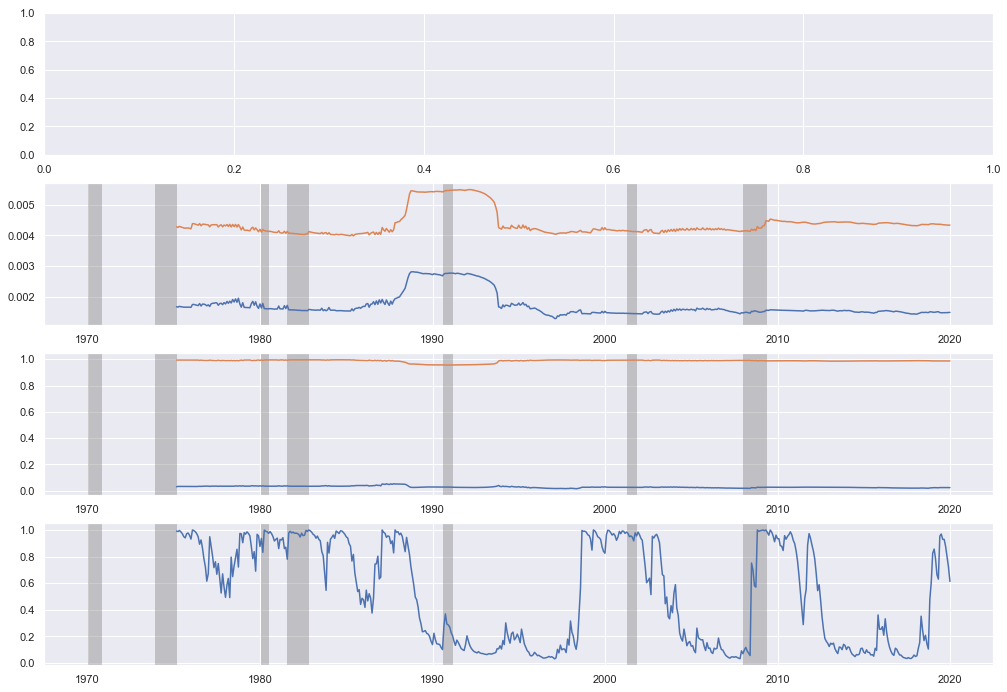

In [83]:
fix,axes = plt.subplots(4,1,figsize=[17,12])

#ax = axes[0]
#plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
#d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'mu_0'),(hmm_name,'mu_1')]]
#d.index = d.index.get_level_values('Date')
#ax.plot(d)

ax = axes[1]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'sigma2_0'),(hmm_name,'sigma2_1')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[2]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'p00'),(hmm_name,'p10')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[3]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
s = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'filt_prob_1')]]
s.index = s.index.get_level_values('Date')
ax.plot(s)

plt.show()

In [99]:
p=df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'p00'),(hmm_name,'p10')]].mean()
p[0] = 1-p[0]
1/(1-p)/12

HMM_roll_40  p00   2.9146
             p10   7.4420
dtype: float64

In [100]:
p

HMM_roll_40  p00   0.9714
             p10   0.9888
dtype: float64

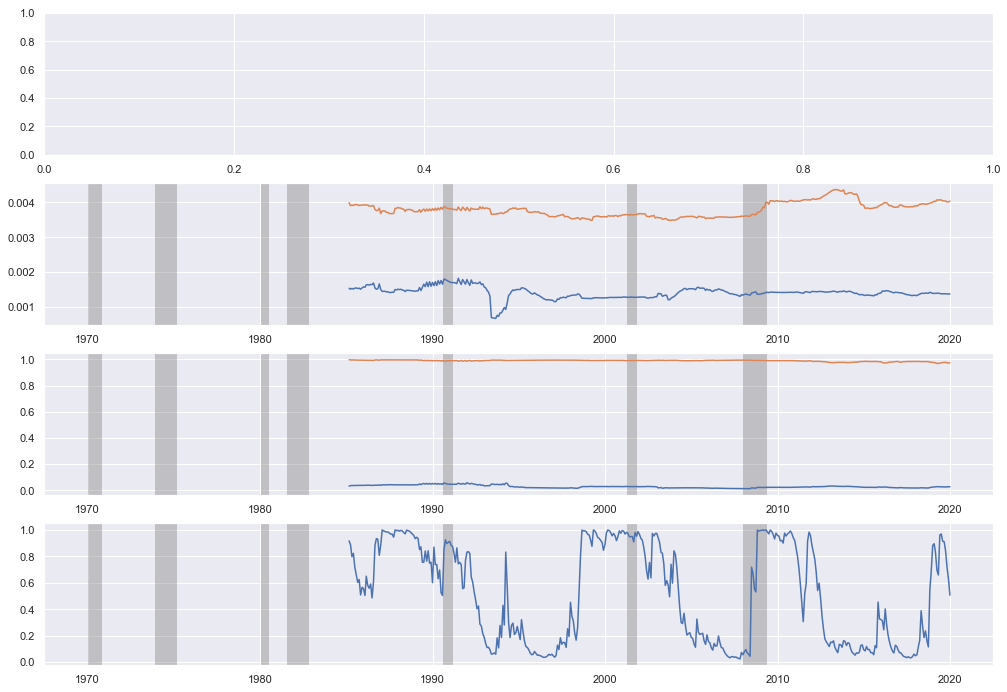

In [101]:
fix,axes = plt.subplots(4,1,figsize=[17,12])

#ax = axes[0]
#plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
#d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'mu_0'),(hmm_name,'mu_1')]]
#d.index = d.index.get_level_values('Date')
#ax.plot(d)

ax = axes[1]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'sigma2_0'),(hmm_name,'sigma2_1')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[2]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'p00'),(hmm_name,'p10')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[3]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
s = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'filt_prob_1')]]
s.index = s.index.get_level_values('Date')
ax.plot(s)

plt.show()